## Let's build customized RAG!

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [3]:
from haystack import Pipeline
from haystack.utils import Secret
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.writers import DocumentWriter

from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder


In [3]:
from haystack.components.builders import PromptBuilder
from haystack.components.generators import HuggingFaceAPIGenerator
from haystack.components.generators import OpenAIGenerator


from haystack.document_stores.types import DuplicatePolicy

In [5]:
document_store = InMemoryDocumentStore()

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store, policy=DuplicatePolicy.OVERWRITE)

indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter", "embedder")
indexing.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

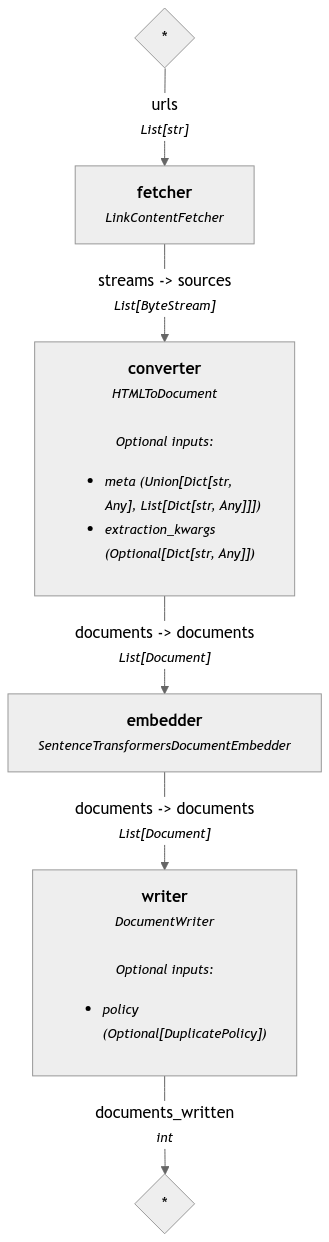

In [6]:
indexing.show()

In [7]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
                
            ]
        }
    }
)

Batches: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


{'writer': {'documents_written': 4}}

In [8]:
document_store.filter_documents()[0].meta['url']

'https://haystack.deepset.ai/integrations/cohere'

## Retrieval Augmented Generation
### 1. Decide on the Prompt
Augment the prompt with the contents of these documents using the [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder?utm_campaign=developer-relations&utm_source=dlai).

In [9]:
prompt = """
Answer the question based on the provided context.  
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""

### 2. Build the Pipeline

In [10]:
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "HuggingFaceH4/zephyr-7b-beta"},
                                    token=Secret.from_token(HF_API_TOKEN))

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: HuggingFaceAPIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

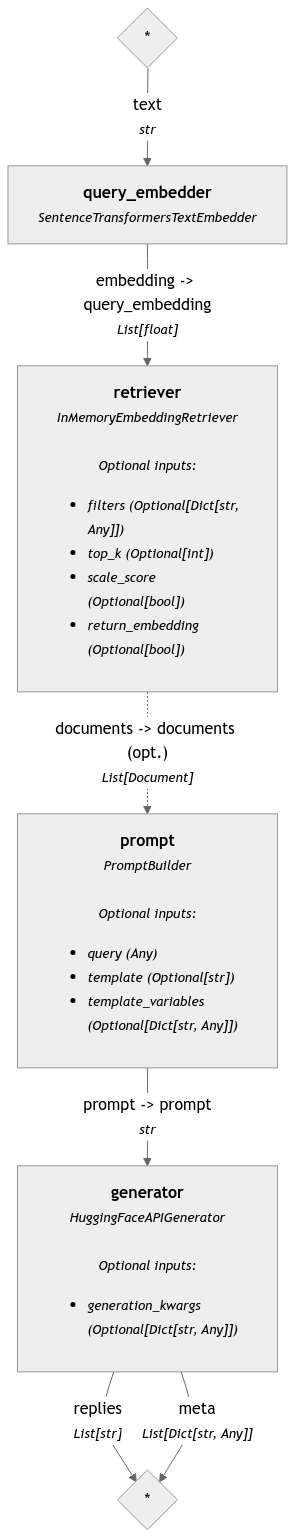

In [11]:
rag.show()

In [12]:
question = "How can I use Cohere with Haystack?"



result = rag.run(
    {"query_embedder": {"text": question},
    "retriever": {"top_k":3}, 
    "prompt": {"query": question}},
        include_outputs_from={"retriever"}
)


for i, document in enumerate(result["retriever"]["documents"]):
    rich.print("\n--------------\n")
    rich.print(f"DOCUMENT {i}")
    rich.print(f"SCORE: {document.score}") #document.score is the raw similarity score between the query and the documents. 
    rich.print(document.content)


Batches: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]

--------------

DOCUMENT 0

SCORE: 0.6590803931435194

Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Haystack 2.0
You can use Cohere Models in your Haystack 2.0 pipelines with the Generators and Embedders.
Installation
pip install cohere-haystack
Usage
You can use Cohere models in various ways:
Embedding Models
You can leverage /embed
models from Cohere through two components:
CohereTextEmbedder and
CohereDocumentEmbedder. These components support both Embed v2 and Embed v3 models.
To create semantic embeddings for documents, use CohereDocumentEmbedder
in your indexing pipeline. For generating embeddings for queries, use CohereTextEmbedder
. Once you’ve selected the suitable component for your specific use case, initialize the component with the model 
name. By default, the Cohere API key with be automatically read from either the COHERE_API_KEY
environment variable or the CO_API_KEY
environment variable.
Below is the example indexing pipeline with InMemoryDocumentStore
, CohereDocumentEmbedder
and DocumentWriter
:
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder
document_store = InMemoryDocumentStore()
documents = [Document(content="My name is Wolfgang and I live in Berlin"),
Document(content="I saw a black horse running"),
Document(content="People speak French in France"),
Document(content="Germany has many big cities")]
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("embedder", CohereDocumentEmbedder(model="embed-multilingual-v3.0", 
input_type="search_document"))
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.connect("embedder", "writer")
indexing_pipeline.run({"embedder": {"documents": documents}})
Generative Models (LLMs)
To use /generate
models from Cohere, initialize a
CohereGenerator with the model name. By default, the Cohere API key with be automatically read from either the 
COHERE_API_KEY
environment variable or the CO_API_KEY
environment variable. You can then use this CohereGenerator
in a question answering pipeline after the PromptBuilder
.
Below is the example of generative questions answering pipeline using RAG with PromptBuilder
and CohereGenerator
:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.embedders.cohere import CohereTextEmbedder
from haystack_integrations.components.generators.cohere import CohereGenerator
template = """
Given the following information, answer the question.
Context:
{% for document in documents %}
{{ document.text }}
{% endfor %}
Question: What's the official language of {{ country }}?
"""
pipe = Pipeline()
pipe.add_component("embedder", CohereTextEmbedder(model="embed-multilingual-v3.0"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", CohereGenerator(model="command-light"))
pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.run({
"embedder": {"text": "France"},
"prompt_builder": {"country": "France"}
})
Similar to the above example, you can also use
CohereChatGenerator
to use Cohere /chat
models and features (streaming, connectors) in your pipeline.
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack_integrations.components.generators.cohere.chat import CohereChatGenerator
pipe = Pipeline()
pipe.add_component("prompt_builder", ChatPromptBuilder())
pipe.add_component("llm", CohereChatGenerator())
pipe.connect("prompt_builder", "llm")

--------------

DOCUMENT 1

SCORE: 0.3886679305701034

Integration: Anthropic
Use Anthropic Models with Haystack
Table of Contents
Overview
This integration supports Anthropic Claude models provided through Anthropic’s own inferencing infrastructure. For 
a full list of available models, check out the Anthropic Claude documentation.
Haystack 2.0
You can use Anthropic models with
AnthropicGenerator
and
AnthropicChatGenerator
.
Currently, available models are:
claude-2.1
claude-3-haiku-20240307
claude-3-sonnet-20240229
(default)claude-3-opus-20240229
Installation
pip install anthropic-haystack
Usage
Based on your use case, you can choose between
AnthropicGenerator
or
AnthropicChatGenerator
to work with Anthropic models. To learn more about the difference, visit the
Generators vs Chat Generators guide.
Before using, make sure to set the ANTHROPIC_API_KEY
environment variable.
Using AnthropicChatGenerator
Below is an example RAG Pipeline where we answer a predefined question using the contents from the below mentioned 
URL pointing to Anthropic prompt engineering guide. We fetch the contents of the URL and generate an answer with 
the AnthropicChatGenerator
.
# To run this example, you will need to set a `ANTHROPIC_API_KEY` environment variable.
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators.utils import print_streaming_chunk
from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack_integrations.components.generators.anthropic import AnthropicChatGenerator
messages = [
ChatMessage.from_system("You are a prompt expert who answers questions based on the given documents."),
ChatMessage.from_user(
"Here are the documents:\n"
"{% for d in documents %} \n"
" {{d.content}} \n"
"{% endfor %}"
"\nAnswer: {{query}}"
),
]
rag_pipeline = Pipeline()
rag_pipeline.add_component("fetcher", LinkContentFetcher())
rag_pipeline.add_component("converter", HTMLToDocument())
rag_pipeline.add_component("prompt_builder", ChatPromptBuilder(variables=["documents"]))
rag_pipeline.add_component(
"llm",
AnthropicChatGenerator(
api_key=Secret.from_env_var("ANTHROPIC_API_KEY"),
streaming_callback=print_streaming_chunk,
),
)
rag_pipeline.connect("fetcher", "converter")
rag_pipeline.connect("converter", "prompt_builder")
rag_pipeline.connect("prompt_builder.prompt", "llm.messages")
question = "When should we use prompt engineering and when should we fine-tune?"
rag_pipeline.run(
data={
"fetcher": {"urls": ["https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview"]},
"prompt_builder": {"template_variables": {"query": question}, "template": messages},
}
)
Using AnthropicGenerator
Below is an example of using AnthropicGenerator
:
from haystack_integrations.components.generators.anthropic import AnthropicGenerator
client = AnthropicGenerator()
response = client.run("What's Natural Language Processing? Be brief.")
print(response)
>>{'replies': ['Natural language processing (NLP) is a branch of artificial intelligence focused on enabling
>>computers to understand, interpret, and manipulate human language. The goal of NLP is to read, decipher,
>> understand, and make sense of the human languages in a manner that is valuable.'], 'meta': {'model':
>> 'claude-2.1', 'index': 0, 'finish_reason': 'end_turn', 'usage': {'input_tokens': 18, 'output_tokens': 58}}}
Haystack 1.x
You can use Anhtropic Claude in your Haystack 1.x pipelines with the PromptNode, which can also be used with and 
Agent.
Installation (1.x)
pip install farm-haystack
Usage (1.x)
You can use Anthropic models in various ways:
Using Claude with PromptNode
To use Claude for prompting and generating answers, initialize a PromptNode
with the model name, your Anthropic API key and a prompt template. You can then use this PromptNode
in a question answering pipeline to generate answers based on the given context.
Below 

--------------

DOCUMENT 2

SCORE: 0.36881232205830167

Integration: NVIDIA
Use NVIDIA models with Haystack.
Table of Contents
Overview
NVIDIA AI Foundation Models and NVIDIA Inference Microservices allow you to reach optimal performance on NVIDIA 
accelerated infrastructure. With pretrained generative AI models, enterprises can create custom models faster and 
take advantage of the latest training and inference techniques.
This integration allows you to use NVIDIA Foundation Models and NVIDIA Inference Microservices in your Haystack 
pipelines.
In order to use this integration, you’ll need a
NVIDIA API key. Set it as an environment variable, NVIDIA_API_KEY
.
Installation
pip install nvidia-haystack
Usage
Components
This integration introduces the following components:
-
NvidiaTextEmbedder
: A component for embedding strings, using NVIDIA AI Foundation and NVIDIA Inference Microservices embedding 
models.For models that differentiate between query and document inputs, this component embeds the input string as a
query.
-
NvidiaDocumentEmbedder
: A component for embedding documents, using NVIDIA AI Foundation and NVIDIA Inference Microservices embedding 
models. -
NvidiaGenerator
: A component for generating text using generative models provided by NVIDIA AI Foundation Endpoints and NVIDIA 
Inference Microservices. -
NvidiaRanker
: A component for ranking documents, using NVIDIA NIMs.
Use the components on their own:
NvidiaTextEmbedder
:
from haystack_integrations.components.embedders.nvidia import NvidiaTextEmbedder
text_to_embed = "I love pizza!"
text_embedder = NvidiaTextEmbedder(model="nvolveqa_40k")
text_embedder.warm_up()
print(text_embedder.run(text_to_embed))
# {'embedding': [-0.02264290489256382, -0.03457780182361603, ...}
NvidiaDocumentEmbedder
:
from haystack.dataclasses import Document
from haystack_integrations.components.embedders.nvidia import NvidiaDocumentEmbedder
documents = [Document(content="Pizza is made with dough and cheese"),
Document(content="Cake is made with floud and sugar"),
Document(content="Omlette is made with eggs")]
document_embedder = NvidiaDocumentEmbedder(model="nvolveqa_40k")
document_embedder.warm_up()
document_embedder.run(documents=documents)
#{'documents': [Document(id=2136941caed9b4667d83f906a80d9a2fad1ce34861392889016830ac8738e6c4, content: 'Pizza is 
made with dough and cheese', embedding: vector of size 1024), ... 'meta': {'usage': {'prompt_tokens': 36, 
'total_tokens': 36}}}
NvidiaGenerator
:
from haystack_integrations.components.generators.nvidia import NvidiaGenerator
generator = NvidiaGenerator(
model="nv_llama2_rlhf_70b",
model_arguments={
"temperature": 0.2,
"top_p": 0.7,
"max_tokens": 1024,
"seed": None,
"bad": None,
"stop": None,
},
)
generator.warm_up()
result = generator.run(prompt="When was the Golden Gate Bridge built?")
print(result["replies"])
print(result["meta"])
# ['The Golden Gate Bridge was built in 1937 and was completed and opened to the public on May 29, 
1937....'[{'role': 'assistant', 'finish_reason': 'stop'}]
NvidiaRanker
:
from haystack_integrations.components.rankers.nvidia import NvidiaRanker
from haystack import Document
from haystack.utils import Secret
ranker = NvidiaRanker(
api_key=Secret.from_env_var("NVIDIA_API_KEY"),
)
ranker.warm_up()
query = "What is the capital of Germany?"
documents = [
Document(content="Berlin is the capital of Germany."),
Document(content="The capital of Germany is Berlin."),
Document(content="Germany's capital is Berlin."),
]
result = ranker.run(query, documents, top_k=1)
print(result["documents"][0].content)
# The capital of Germany is Berlin.
Use NVIDIA components in Haystack pipelines
Indexing pipeline
from haystack_integrations.components.generators.nvidia import NvidiaGenerator
from haystack_integrations.components.embedders.nvidia import NvidiaDocumentEmbedder
from haystack import Pipeline
from haystack.dataclasses import Document
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
documents = [Document(

In [13]:
rich.print(result["generator"]["replies"][0])

Answer:

To use Cohere models with Haystack, you can install the cohere-haystack package and use the CohereEmbedder and 
CohereGenerator components provided by the package. Here's an example of how to use CohereEmbedder in an indexing 
pipeline:

```python
from cohere-haystack import CohereEmbedder
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.pipelines import Pipeline
from haystack.utils import Secret

document_store = InMemoryDocumentStore()
writer = DocumentWriter(document_store=document_store)
embedder = CohereEmbedder(model="embed-multilingual-v3.0", api_key=Secret.from_env_var("COHERE_API_KEY"))

indexing_pipeline = Pipeline()
indexing_pipeline.add_component(instance=embedder, name="embedder")
indexing_pipeline.add_component(instance=writer, name="writer")
indexing_pipeline.connect("embedder.embedding", "writer.embedding")

# Run the pipeline with some documents
indexing_pipeline.run({"embedder": {"documents": [Document(content="My name is Wolfgang and I live in Berlin"), 
Document(content="I saw a black horse running"), Document(content="People speak French in France"), 
Document(content="Germany has many big cities")]}})
```

In this example, we're using the `CohereEmbedder` component to embed the documents using the 
`embed-multilingual-v3.0` model provided by Cohere. The `api_key` is passed as an environment variable, but you can
also pass it as a parameter to the `CohereEmbedder` constructor.

To use CohereGenerator in a question answering pipeline, you can follow a similar approach:

```python
from cohere-haystack import CohereGenerator
from haystack.components.builders import ChatPromptBuilder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack

### Ranking

Rankers are a group of components that order documents by given criteria. Their goal is to improve your document retrieval results.

In [14]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://en.wikipedia.org/wiki/Cohere", 
                "https://www.cnbc.com/2024/07/23/cohere-layoffs-20-employees-cut-following-500-million-funding.html",
                "https://medium.com/@nagaraj.jayakumar/building-a-hybrid-search-system-with-cohere-and-pinecone-part-1-e85d746b367f"
            ]
        }
    }
)

Batches: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]


{'writer': {'documents_written': 3}}

In [15]:
document_store.count_documents()

7

In [16]:
from haystack.components.rankers import TransformersSimilarityRanker

In [17]:
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
ranker = TransformersSimilarityRanker()
prompt_builder = PromptBuilder(template=prompt)
generator = HuggingFaceAPIGenerator(api_type="serverless_inference_api",
                                    api_params={"model": "HuggingFaceH4/zephyr-7b-beta"},
                                    token=Secret.from_token(HF_API_TOKEN))

ranker_pipeline = Pipeline()
ranker_pipeline.add_component("query_embedder", query_embedder)
ranker_pipeline.add_component("retriever", retriever)
ranker_pipeline.add_component("ranker", ranker)
ranker_pipeline.add_component("prompt", prompt_builder)
ranker_pipeline.add_component("generator", generator)

ranker_pipeline.connect("query_embedder.embedding", "retriever.query_embedding")
ranker_pipeline.connect("retriever.documents", "ranker.documents")
ranker_pipeline.connect("ranker.documents", "prompt.documents")
ranker_pipeline.connect("prompt", "generator")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - ranker: TransformersSimilarityRanker
  - prompt: PromptBuilder
  - generator: HuggingFaceAPIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

In [18]:
question = "How can I use Cohere with Haystack?"



result = ranker_pipeline.run(
    {"query_embedder": {"text": question},
    "retriever": {"top_k":5}, # this top_k select how many documents to retrieve from doc_store to pass to the ranker
    "ranker":{"query": question, "top_k": 2}, # this top_k select how many docs to pass to the prompt as context based on re-ranking
    "prompt": {"query": question}},
        include_outputs_from={"retriever", "ranker"}
)


for i, document in enumerate(result["retriever"]["documents"]):
    rich.print("\n--------------\n")
    rich.print(f"DOCUMENT {i}")
    rich.print(f"SCORE: {document.score}") 
    rich.print(document.content)

for i, document in enumerate(result["ranker"]["documents"]):
    rich.print("\n--------------\n")
    rich.print(f"DOCUMENT {i}")
    rich.print(f"SCORE: {document.score}") 
    rich.print(document.content)

Batches: 100%|██████████| 1/1 [00:00<00:00, 52.60it/s]


--------------

DOCUMENT 0

SCORE: 0.6590803931435194

Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Haystack 2.0
You can use Cohere Models in your Haystack 2.0 pipelines with the Generators and Embedders.
Installation
pip install cohere-haystack
Usage
You can use Cohere models in various ways:
Embedding Models
You can leverage /embed
models from Cohere through two components:
CohereTextEmbedder and
CohereDocumentEmbedder. These components support both Embed v2 and Embed v3 models.
To create semantic embeddings for documents, use CohereDocumentEmbedder
in your indexing pipeline. For generating embeddings for queries, use CohereTextEmbedder
. Once you’ve selected the suitable component for your specific use case, initialize the component with the model 
name. By default, the Cohere API key with be automatically read from either the COHERE_API_KEY
environment variable or the CO_API_KEY
environment variable.
Below is the example indexing pipeline with InMemoryDocumentStore
, CohereDocumentEmbedder
and DocumentWriter
:
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder
document_store = InMemoryDocumentStore()
documents = [Document(content="My name is Wolfgang and I live in Berlin"),
Document(content="I saw a black horse running"),
Document(content="People speak French in France"),
Document(content="Germany has many big cities")]
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("embedder", CohereDocumentEmbedder(model="embed-multilingual-v3.0", 
input_type="search_document"))
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.connect("embedder", "writer")
indexing_pipeline.run({"embedder": {"documents": documents}})
Generative Models (LLMs)
To use /generate
models from Cohere, initialize a
CohereGenerator with the model name. By default, the Cohere API key with be automatically read from either the 
COHERE_API_KEY
environment variable or the CO_API_KEY
environment variable. You can then use this CohereGenerator
in a question answering pipeline after the PromptBuilder
.
Below is the example of generative questions answering pipeline using RAG with PromptBuilder
and CohereGenerator
:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.embedders.cohere import CohereTextEmbedder
from haystack_integrations.components.generators.cohere import CohereGenerator
template = """
Given the following information, answer the question.
Context:
{% for document in documents %}
{{ document.text }}
{% endfor %}
Question: What's the official language of {{ country }}?
"""
pipe = Pipeline()
pipe.add_component("embedder", CohereTextEmbedder(model="embed-multilingual-v3.0"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", CohereGenerator(model="command-light"))
pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.run({
"embedder": {"text": "France"},
"prompt_builder": {"country": "France"}
})
Similar to the above example, you can also use
CohereChatGenerator
to use Cohere /chat
models and features (streaming, connectors) in your pipeline.
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack_integrations.components.generators.cohere.chat import CohereChatGenerator
pipe = Pipeline()
pipe.add_component("prompt_builder", ChatPromptBuilder())
pipe.add_component("llm", CohereChatGenerator())
pipe.connect("prompt_builder", "llm")

--------------

DOCUMENT 1

SCORE: 0.46253451556837855

Cohere
Company type | Private |
---|---|
Industry | |
Founded | 2019 |
Founders | Aidan Gomez, Ivan Zhang, Nick Frosst |
Headquarters | |
Key people |
|
Number of employees | 300 (2024)[1] |
Website | cohere |
Cohere Inc. is a Canadian multinational technology company focused on artificial intelligence for the enterprise, 
specializing in large language models.[2] Cohere was founded in 2019 by Aidan Gomez, Ivan Zhang, and Nick 
Frosst,[3] and is headquartered in Toronto and San Francisco, with offices in Palo Alto, London, and New York 
City.[4][5][6]
History
In 2017, a team of researchers at Google Brain introduced the transformer machine learning architecture in 
"Attention Is All You Need," which demonstrated state-of-the-art performance on a variety of natural language 
processing tasks.[7][8] In 2019, Aidan Gomez, one of its co-authors, along with Nick Frosst, another researcher at 
Google Brain, founded Cohere with Ivan Zhang, with whom Gomez had done research at FOR.ai.[9][10] All of the 
co-founders attended University of Toronto.[11]
Gomez is the company's CEO.[10] In December 2022, Martin Kon, the former CFO of YouTube, became president and 
COO.[12]
In November 2021, Google Cloud announced that they would help power Cohere's platform using their robust 
infrastructure, and Cloud's TPUs would be used by Cohere for the development and deployment of their 
products.[13][14]
In June 2022, Cohere launched Cohere For AI, a nonprofit research lab and community dedicated to contributing 
open-source, fundamental machine learning research. It is led by Sara Hooker, a former research scientist at Google
Brain.[15]
In December 2022, Cohere released a multilingual model for understanding text that would work with over 100 
languages, to help users search for documents by meaning instead of with keywords. This type of process was not 
previously widely available in languages other than English.[12]
On June 13, 2023, Oracle announced a partnership with Cohere to provide generative AI services to help 
organizations automate end-to-end business processes. As a result, Cohere's technology is integrated into Oracle's 
business applications, including Oracle Fusion Cloud, Oracle NetSuite, and Oracle industry-specific 
applications.[16] On July 18, 2023, McKinsey announced a collaboration with Cohere, to help organizations integrate
generative AI into their operations.[17] In 2023, Cohere collaborated with software company LivePerson to offer 
customized large language models for businesses.[2]
On September 12, 2023, it was announced that Cohere had become one of 15 tech companies to agree to voluntary White
House measures on testing, reporting, and research on the risks of AI.[18] On September 27, 2023, it was announced 
that Cohere had also signed Canada's voluntary code of conduct for AI, to promote the responsible development and 
management of advanced generative AI systems.[19]
Products
Considered an alternative to OpenAI,[20] Cohere is focused on generative AI for the enterprise, building technology
that businesses can use to deploy chatbots, search engines, copywriting, summarization, and other AI-driven 
products.[2][21] Cohere specializes in large language models: AI trained to digest text from an enterprises' 
internal data or publicly available sources like the internet to understand how to process and respond to prompts 
with increasing sophistication.[12]
The Cohere platform is available through API as a managed service, through platforms such as Amazon SageMaker and 
Google's Vertex AI. It can be used for tasks such as writing copy, moderating content, classifying data, and 
extracting information. It is cloud agnostic and not tied to a particular cloud service.[10]
Cohere's generative AI technology is embedded into several Oracle products, and its chat capabilities are embedded 
into Salesforce products.[20]
Funding
On September 7, 2021, Cohere announced that they had raised $40 million in Series A funding led by Index

--------------

DOCUMENT 2

SCORE: 0.4525571318162084

Cohere, the artificial intelligence startup founded by ex-Google AI researchers and backed by Nvidia, cut about 20 
roles on Tuesday, CNBC confirmed.
The layoffs at Cohere, which had about 400 employees according to the company, follow the completion of a $500 
million funding round from investors including AMD, Salesforce, Oracle and Nvidia that valued the company at $5.5 
billion — more than doubling its valuation from last year.
Despite the cuts, Cohere is hiring in areas such as customer operations, partnerships, revenue, sales, product 
design and modeling, according to its website.
Founded by ex-Google AI researchers and backed by Nvidia, Cohere's business model has centered on generative AI for
the enterprise rather than on consumer chatbots, which have been the talk of the tech industry since OpenAI 
released ChatGPT in late 2022. In June 2023, Cohere raised $270 million at a $2.2 billion valuation, with 
Salesforce and Oracle participating in the funding round. Company executives have also attended AI forums at the 
White House.
"With our most recent round of financing in place, we have a clear vision for the future of Cohere, which has 
required some internal realignment," a representative for the company told CNBC in a statement. "We will continue 
to aggressively hire people as we work to offer companies the most accurate, secure and private multilingual AI 
solutions in the market."
Fortune first reported on the job cuts.
The generative AI field has exploded over the past year, with a record $29.1 billion invested across nearly 700 
deals in 2023, a more than 260% increase in deal value from a year earlier, according to PitchBook. It's become the
buzziest phrase on corporate earnings calls quarter after quarter, and some form of the technology is automating 
tasks in just about every industry, from financial services and biomedical research to logistics, online travel and
utilities.
Some of Cohere's competitors in the AI arms race offer products for both consumers and businesses. OpenAI, for 
instance, launched ChatGPT Enterprise last August, and Anthropic opened up consumer access to its formerly 
business-only Claude chatbot last July.
Cohere president and Chief Operating Officer Martin Kon told CNBC in March that by staying focused on enterprise 
AI, the company is able to run efficiently and keep costs under control even amid a chip shortage, rising costs for
graphics processing units (GPUs) and ever-changing licensing fees for AI models.
Current clients include Notion, Oracle and Bamboo HR, according to Cohere's website. Many customers include 
businesses in banking, financial services and insurance, Kon told CNBC in the past. In November, Cohere told CNBC 
it saw an uptick in customer interest after OpenAI's sudden and temporary ouster of CEO Sam Altman.
In March, Kon acknowledged that changing dynamics in the hardware industry have presented persistent challenges. 
The company has had a reserve of Google chips for well over two years, Kon said at the time, secured in Cohere's 
early days to help it pretrain its models. Now, Cohere is moving toward using more of Nvidia's H100 GPUs, which are
powering most of the latest large language models.

--------------

DOCUMENT 3

SCORE: 0.41892507343324903

Building a Hybrid Search System with Cohere and Pinecone — Part 1
In the realm of data retrieval, hybrid search systems are revolutionizing how we access information. By combining 
traditional keyword search with cutting-edge vector search, hybrid systems offer enhanced performance and 
adaptability. In this blog post, we will explore how to implement a hybrid search system using Cohere for embedding
generation and Pinecone for vector storage.
Part 1: Setting Up the Environment
To begin, we need to set up our environment by loading necessary libraries and initializing clients for Cohere and 
Pinecone.
# Load environment variables
env_vars = load_environment_variables()
# Initialize Cohere and Pinecone clients
cohere_client, pinecone_client = initialize_clients(env_vars["cohere_api_key"], env_vars["pinecone_api_key"])
Part 2: Extracting and Processing Data
We start by extracting elements from a PDF document. This involves using high-resolution partitioning to ensure 
that tables and text are accurately captured.
Step 2.2: Extract Elements from the PDF
We use a function partition_pdf
to extract elements from the PDF. This function breaks down the document into manageable parts, such as text blocks
and tables, using a high-resolution strategy. It also infers table structures and uses a model named "yolox" for 
chunking by title:
# Define your PDF file path
filename = '/path/to/your/pdf/document.pdf'
# Extract elements from the PDF
orig_elements = partition_pdf(
filename=filename,
strategy="hi_res",
infer_table_structure=True,
model_name="yolox",
chunking_strategy="by_title",
max_characters=4000,
new_after_n_chars=3800,
combine_text_under_n_chars=2000,
)
Step 2.3: Initialize LangChain and Cohere
LangChain and Cohere are initialized to summarize extracted content. LangChain’s ChatCohere
model is set up with a specific temperature and model name for generating concise summaries:
llm = ChatCohere(temperature=0, model_name="command-r-plus")
chain = load_summarize_chain(llm, chain_type="stuff")
Step 2.4: Copy and Group Elements by Page Number
The extracted elements are deep-copied to preserve the original structure. They are then grouped by page number to 
facilitate further processing:
elements = copy.deepcopy(orig_elements)
page_content = defaultdict(list)
for element in elements:
if isinstance(element, (CompositeElement, Table)):
page_number = element.metadata.page_number if element.metadata else None
if page_number is not None:
page_content.append(element)
Step 2.5: Process Each Page for Headers and Footers
For each page, headers and footers are identified around tables. This involves iterating through elements on each 
page and distinguishing between headers, footers, and table content:
all_tables_info = []
for page, elements in tqdm(page_content.items(), desc="Processing Pages"):
header_text = ""
footer_text = ""
found_first_table = False
for elem in elements:
if isinstance(elem, CompositeElement):
if not found_first_table:
header_text += elem.text + "\n"
else:
footer_text += elem.text + "\n"
elif isinstance(elem, Table):
found_first_table = True
Step 2.6: Summarize Tables with Headers and Footers
Tables are processed to extract HTML content and text. LangChain is used to generate summaries of these tables, 
which are then combined with headers and footers:
table_index = 0
for elem in elements:
if isinstance(elem, Table):
html_content = elem.metadata.text_as_html if elem.metadata and hasattr(elem.metadata, 'text_as_html') else "No HTML
content"
table_text = elem.text
documents = [Document(page_content=html_content), Document(page_content=table_text)]
res = chain.invoke(documents)
combined_text = f"{header_text.strip()}\n{res['output_text']}\n{html_content}\n{footer_text.strip()}"
transformed_data = {
"id": f"chunk-3-page-{page}-table-{table_index}",
"text": combined_text,
"metadata": {
"context": combined_text,
"page": page,
"type": "Table",
"id": f"chunk-3-page-{page}-table-{table_index}",
"summary": res['output_text'],
"html": 

--------------

DOCUMENT 4

SCORE: 0.3886679305701034

Integration: Anthropic
Use Anthropic Models with Haystack
Table of Contents
Overview
This integration supports Anthropic Claude models provided through Anthropic’s own inferencing infrastructure. For 
a full list of available models, check out the Anthropic Claude documentation.
Haystack 2.0
You can use Anthropic models with
AnthropicGenerator
and
AnthropicChatGenerator
.
Currently, available models are:
claude-2.1
claude-3-haiku-20240307
claude-3-sonnet-20240229
(default)claude-3-opus-20240229
Installation
pip install anthropic-haystack
Usage
Based on your use case, you can choose between
AnthropicGenerator
or
AnthropicChatGenerator
to work with Anthropic models. To learn more about the difference, visit the
Generators vs Chat Generators guide.
Before using, make sure to set the ANTHROPIC_API_KEY
environment variable.
Using AnthropicChatGenerator
Below is an example RAG Pipeline where we answer a predefined question using the contents from the below mentioned 
URL pointing to Anthropic prompt engineering guide. We fetch the contents of the URL and generate an answer with 
the AnthropicChatGenerator
.
# To run this example, you will need to set a `ANTHROPIC_API_KEY` environment variable.
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators.utils import print_streaming_chunk
from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack_integrations.components.generators.anthropic import AnthropicChatGenerator
messages = [
ChatMessage.from_system("You are a prompt expert who answers questions based on the given documents."),
ChatMessage.from_user(
"Here are the documents:\n"
"{% for d in documents %} \n"
" {{d.content}} \n"
"{% endfor %}"
"\nAnswer: {{query}}"
),
]
rag_pipeline = Pipeline()
rag_pipeline.add_component("fetcher", LinkContentFetcher())
rag_pipeline.add_component("converter", HTMLToDocument())
rag_pipeline.add_component("prompt_builder", ChatPromptBuilder(variables=["documents"]))
rag_pipeline.add_component(
"llm",
AnthropicChatGenerator(
api_key=Secret.from_env_var("ANTHROPIC_API_KEY"),
streaming_callback=print_streaming_chunk,
),
)
rag_pipeline.connect("fetcher", "converter")
rag_pipeline.connect("converter", "prompt_builder")
rag_pipeline.connect("prompt_builder.prompt", "llm.messages")
question = "When should we use prompt engineering and when should we fine-tune?"
rag_pipeline.run(
data={
"fetcher": {"urls": ["https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview"]},
"prompt_builder": {"template_variables": {"query": question}, "template": messages},
}
)
Using AnthropicGenerator
Below is an example of using AnthropicGenerator
:
from haystack_integrations.components.generators.anthropic import AnthropicGenerator
client = AnthropicGenerator()
response = client.run("What's Natural Language Processing? Be brief.")
print(response)
>>{'replies': ['Natural language processing (NLP) is a branch of artificial intelligence focused on enabling
>>computers to understand, interpret, and manipulate human language. The goal of NLP is to read, decipher,
>> understand, and make sense of the human languages in a manner that is valuable.'], 'meta': {'model':
>> 'claude-2.1', 'index': 0, 'finish_reason': 'end_turn', 'usage': {'input_tokens': 18, 'output_tokens': 58}}}
Haystack 1.x
You can use Anhtropic Claude in your Haystack 1.x pipelines with the PromptNode, which can also be used with and 
Agent.
Installation (1.x)
pip install farm-haystack
Usage (1.x)
You can use Anthropic models in various ways:
Using Claude with PromptNode
To use Claude for prompting and generating answers, initialize a PromptNode
with the model name, your Anthropic API key and a prompt template. You can then use this PromptNode
in a question answering pipeline to generate answers based on the given context.
Below 

--------------

DOCUMENT 0

SCORE: 0.9994614720344543

Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Haystack 2.0
You can use Cohere Models in your Haystack 2.0 pipelines with the Generators and Embedders.
Installation
pip install cohere-haystack
Usage
You can use Cohere models in various ways:
Embedding Models
You can leverage /embed
models from Cohere through two components:
CohereTextEmbedder and
CohereDocumentEmbedder. These components support both Embed v2 and Embed v3 models.
To create semantic embeddings for documents, use CohereDocumentEmbedder
in your indexing pipeline. For generating embeddings for queries, use CohereTextEmbedder
. Once you’ve selected the suitable component for your specific use case, initialize the component with the model 
name. By default, the Cohere API key with be automatically read from either the COHERE_API_KEY
environment variable or the CO_API_KEY
environment variable.
Below is the example indexing pipeline with InMemoryDocumentStore
, CohereDocumentEmbedder
and DocumentWriter
:
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder
document_store = InMemoryDocumentStore()
documents = [Document(content="My name is Wolfgang and I live in Berlin"),
Document(content="I saw a black horse running"),
Document(content="People speak French in France"),
Document(content="Germany has many big cities")]
indexing_pipeline = Pipeline()
indexing_pipeline.add_component("embedder", CohereDocumentEmbedder(model="embed-multilingual-v3.0", 
input_type="search_document"))
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.connect("embedder", "writer")
indexing_pipeline.run({"embedder": {"documents": documents}})
Generative Models (LLMs)
To use /generate
models from Cohere, initialize a
CohereGenerator with the model name. By default, the Cohere API key with be automatically read from either the 
COHERE_API_KEY
environment variable or the CO_API_KEY
environment variable. You can then use this CohereGenerator
in a question answering pipeline after the PromptBuilder
.
Below is the example of generative questions answering pipeline using RAG with PromptBuilder
and CohereGenerator
:
from haystack import Pipeline
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack_integrations.components.embedders.cohere import CohereTextEmbedder
from haystack_integrations.components.generators.cohere import CohereGenerator
template = """
Given the following information, answer the question.
Context:
{% for document in documents %}
{{ document.text }}
{% endfor %}
Question: What's the official language of {{ country }}?
"""
pipe = Pipeline()
pipe.add_component("embedder", CohereTextEmbedder(model="embed-multilingual-v3.0"))
pipe.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store))
pipe.add_component("prompt_builder", PromptBuilder(template=template))
pipe.add_component("llm", CohereGenerator(model="command-light"))
pipe.connect("embedder.embedding", "retriever.query_embedding")
pipe.connect("retriever", "prompt_builder.documents")
pipe.connect("prompt_builder", "llm")
pipe.run({
"embedder": {"text": "France"},
"prompt_builder": {"country": "France"}
})
Similar to the above example, you can also use
CohereChatGenerator
to use Cohere /chat
models and features (streaming, connectors) in your pipeline.
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.dataclasses import ChatMessage
from haystack_integrations.components.generators.cohere.chat import CohereChatGenerator
pipe = Pipeline()
pipe.add_component("prompt_builder", ChatPromptBuilder())
pipe.add_component("llm", CohereChatGenerator())
pipe.connect("prompt_builder", "llm")

--------------

DOCUMENT 1

SCORE: 0.6067165732383728

Integration: Anthropic
Use Anthropic Models with Haystack
Table of Contents
Overview
This integration supports Anthropic Claude models provided through Anthropic’s own inferencing infrastructure. For 
a full list of available models, check out the Anthropic Claude documentation.
Haystack 2.0
You can use Anthropic models with
AnthropicGenerator
and
AnthropicChatGenerator
.
Currently, available models are:
claude-2.1
claude-3-haiku-20240307
claude-3-sonnet-20240229
(default)claude-3-opus-20240229
Installation
pip install anthropic-haystack
Usage
Based on your use case, you can choose between
AnthropicGenerator
or
AnthropicChatGenerator
to work with Anthropic models. To learn more about the difference, visit the
Generators vs Chat Generators guide.
Before using, make sure to set the ANTHROPIC_API_KEY
environment variable.
Using AnthropicChatGenerator
Below is an example RAG Pipeline where we answer a predefined question using the contents from the below mentioned 
URL pointing to Anthropic prompt engineering guide. We fetch the contents of the URL and generate an answer with 
the AnthropicChatGenerator
.
# To run this example, you will need to set a `ANTHROPIC_API_KEY` environment variable.
from haystack import Pipeline
from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators.utils import print_streaming_chunk
from haystack.dataclasses import ChatMessage
from haystack.utils import Secret
from haystack_integrations.components.generators.anthropic import AnthropicChatGenerator
messages = [
ChatMessage.from_system("You are a prompt expert who answers questions based on the given documents."),
ChatMessage.from_user(
"Here are the documents:\n"
"{% for d in documents %} \n"
" {{d.content}} \n"
"{% endfor %}"
"\nAnswer: {{query}}"
),
]
rag_pipeline = Pipeline()
rag_pipeline.add_component("fetcher", LinkContentFetcher())
rag_pipeline.add_component("converter", HTMLToDocument())
rag_pipeline.add_component("prompt_builder", ChatPromptBuilder(variables=["documents"]))
rag_pipeline.add_component(
"llm",
AnthropicChatGenerator(
api_key=Secret.from_env_var("ANTHROPIC_API_KEY"),
streaming_callback=print_streaming_chunk,
),
)
rag_pipeline.connect("fetcher", "converter")
rag_pipeline.connect("converter", "prompt_builder")
rag_pipeline.connect("prompt_builder.prompt", "llm.messages")
question = "When should we use prompt engineering and when should we fine-tune?"
rag_pipeline.run(
data={
"fetcher": {"urls": ["https://docs.anthropic.com/en/docs/build-with-claude/prompt-engineering/overview"]},
"prompt_builder": {"template_variables": {"query": question}, "template": messages},
}
)
Using AnthropicGenerator
Below is an example of using AnthropicGenerator
:
from haystack_integrations.components.generators.anthropic import AnthropicGenerator
client = AnthropicGenerator()
response = client.run("What's Natural Language Processing? Be brief.")
print(response)
>>{'replies': ['Natural language processing (NLP) is a branch of artificial intelligence focused on enabling
>>computers to understand, interpret, and manipulate human language. The goal of NLP is to read, decipher,
>> understand, and make sense of the human languages in a manner that is valuable.'], 'meta': {'model':
>> 'claude-2.1', 'index': 0, 'finish_reason': 'end_turn', 'usage': {'input_tokens': 18, 'output_tokens': 58}}}
Haystack 1.x
You can use Anhtropic Claude in your Haystack 1.x pipelines with the PromptNode, which can also be used with and 
Agent.
Installation (1.x)
pip install farm-haystack
Usage (1.x)
You can use Anthropic models in various ways:
Using Claude with PromptNode
To use Claude for prompting and generating answers, initialize a PromptNode
with the model name, your Anthropic API key and a prompt template. You can then use this PromptNode
in a question answering pipeline to generate answers based on the given context.
Below 

In [19]:
rich.print(result["generator"]["replies"][0])

Answer:

To use Cohere with Haystack, you can follow the instructions provided in the Cohere integration guide for either 
Haystack 2.0 or Haystack 1.x. The guide explains how to install the necessary packages, set up the environment 
variables, and use the Cohere components in your pipelines. It also provides examples of how to use Cohere's 
embedding, generation, and ranking models in your question answering and document retrieval tasks. Additionally, 
the guide explains how to use Anthropic models with Haystack and provides examples of how to use Anthropic's Claude
models for prompting and generating answers.

### 3. Customize The Behaviour

In [20]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }} 
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""

Here we use also a re-ranker to rank the documents retrieved by the retriever. 

We use the **Transformer Similairty Ranker**: it ranks documents based on how similar they are to the query. It uses a pre-trained cross-encoder model from the Hugging Face Hub to embed both the query and the documents. 

In [23]:
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
ranker = TransformersSimilarityRanker()
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))

ranker_pipeline = Pipeline()
ranker_pipeline.add_component("query_embedder", query_embedder)
ranker_pipeline.add_component("retriever", retriever)
ranker_pipeline.add_component("ranker", ranker)
ranker_pipeline.add_component("prompt", prompt_builder)
ranker_pipeline.add_component("generator", generator)

ranker_pipeline.connect("query_embedder.embedding", "retriever.query_embedding")
ranker_pipeline.connect("retriever.documents", "ranker.documents")
ranker_pipeline.connect("ranker.documents", "prompt.documents")
ranker_pipeline.connect("prompt", "generator")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - ranker: TransformersSimilarityRanker
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

In [24]:
question = "How can I use Cohere with Haystack?"

result = ranker_pipeline.run(
    {"query_embedder": {"text": question},
    "retriever": {"top_k":5}, # this top_k select how many documents to retrieve from doc_store to pass to the ranker
    "ranker":{"query": question, "top_k": 2}, # this top_k select how many docs to pass to the prompt as context based on re-ranking
    "prompt": {"query": question, "language":"Italian"}},
        include_outputs_from={"prompt"}
)
rich.print(result["generator"]["replies"][0])

Batches: 100%|██████████| 1/1 [00:00<00:00, 21.74it/s]


Puoi utilizzare i modelli Cohere con Haystack 2.0 attraverso i componenti Generators e Embedders. Per utilizzare i 
modelli di embedding, come CohereDocumentEmbedder e CohereTextEmbedder, devi installare il pacchetto con il comando
`pip install cohere-haystack`. Una volta installato, puoi creare pipeline di indicizzazione e generazione 
utilizzando i modelli Cohere per creare embedding semantici per documenti e query.

Ecco un esempio per utilizzare CohereDocumentEmbedder in una pipeline di indexing:

```python
from haystack import Document, Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder

document_store = InMemoryDocumentStore()
documents = [Document(content="Il mio nome è Wolfgang e vivo a Berlino"),
             Document(content="Ho visto un cavallo nero correre"),
             Document(content="Le persone parlano francese in Francia"),
             Document(content="La Germania ha molte grandi città")]

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("embedder", CohereDocumentEmbedder(model="embed-multilingual-v3.0", 
input_type="search_document"))
indexing_pipeline.add_component("writer", DocumentWriter(document_store=document_store))
indexing_pipeline.connect("embedder", "writer")
indexing_pipeline.run({"embedder": {"documents": documents}})
```

Puoi anche utilizzare modelli generativi con Cohere, come CohereGenerator, per creare risposte a domande in una 
pipeline di domanda e risposta dopo aver configurato il PromptBuilder.

Per ulteriori dettagli, puoi visitare il sito ufficiale: [Haystack - Cohere 
Integration](https://haystack.deepset.ai/integrations/cohere).